## Try to implement QAOA for:

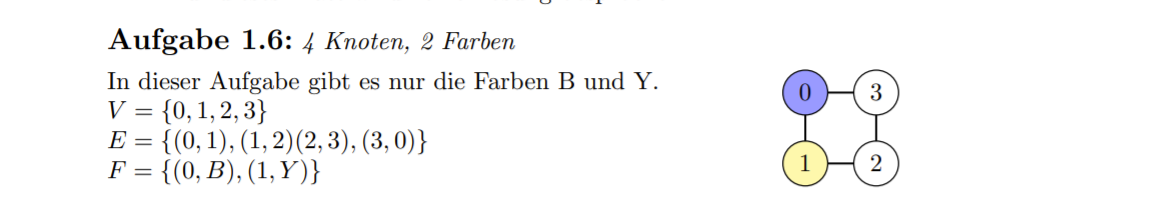

In [1]:
import sys
import time
import numpy as np
import pandas as pd
import pennylane as qml
import seaborn as sns
from dwave_qbsolv import QBSolv
from matplotlib import pyplot as plt
from pennylane import qaoa
import copy
import progressbar
import os
import os.path
from qiskit import IBMQ

import dimod.utilities

In [2]:
n = 4
QUBO = np.zeros((n, n))
np.fill_diagonal(QUBO,2)
QUBO[0][3] = -2
QUBO[0][1] = -2
QUBO[1][2] = -2
QUBO[2][3] = -2

In [3]:
QUBO = (-1) * QUBO

In [4]:
qubo_d = {}
x1 = 0
while x1 < n:
    x2 = x1
    while x2 < n:
        qubo_d[(x1, x2)] = int(QUBO[x1][x2])
        x2 += 1
    x1 += 1
    
print(qubo_d)

{(0, 0): -2, (0, 1): 2, (0, 2): 0, (0, 3): 2, (1, 1): -2, (1, 2): 2, (1, 3): 0, (2, 2): -2, (2, 3): 2, (3, 3): -2}


In [5]:
isingX = dimod.qubo_to_ising(qubo_d, 0)
print(isingX)
(linear, quadratic, _) = isingX
print("\n")
print(linear)
print("\n")
print(quadratic)

({0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0}, {(0, 1): 0.5, (0, 3): 0.5, (1, 2): 0.5, (2, 3): 0.5}, -2.0)


{0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0}


{(0, 1): 0.5, (0, 3): 0.5, (1, 2): 0.5, (2, 3): 0.5}


In [6]:
n_qubits = n
wires = range(n_qubits)
depthX = 1

In [7]:
linear_coefficents = [linear[i] for i in range(n_qubits) if i in linear]
linear_gates = [qml.PauliZ(i) for i in range(n_qubits) if i in linear]
quadratic_coefficents = [quadratic[(i, j)] for i in range(n_qubits) for j in range(n_qubits) if (i, j) in quadratic]
quadratic_gates = [qml.PauliZ(i) @ qml.PauliZ(j) for i in range(n_qubits) for j in range(n_qubits) if
                       (i, j) in quadratic]

coefficents = linear_coefficents + quadratic_coefficents
gates = linear_gates + quadratic_gates

cost_h = qml.Hamiltonian(coefficents, gates)

In [8]:
print(cost_h)

  (0.0) [Z0]
+ (0.0) [Z1]
+ (0.0) [Z2]
+ (0.0) [Z3]
+ (0.5) [Z0 Z1]
+ (0.5) [Z0 Z3]
+ (0.5) [Z1 Z2]
+ (0.5) [Z2 Z3]


In [9]:
mixer_h = qaoa.x_mixer(0)
for i in range(n_qubits - 1):
    mixer_h += qaoa.x_mixer(i + 1)

In [10]:
print(mixer_h)

  (1) [X0]
+ (1) [X1]
+ (1) [X2]
+ (1) [X3]


In [11]:
def qaoa_layer(gamma, alpha):
    qaoa.cost_layer(gamma, cost_h)
    qaoa.mixer_layer(alpha, mixer_h)

In [12]:
def circuit(params, **kwargs):
    for w in wires:
        qml.Hadamard(wires=w)
    qml.layer(qaoa_layer, depthX, params[0], params[1])

In [13]:
token = '1c854f9916477c15b8ef30c1243313b67e739cfc30f10cd741d7ad787f102bca0f0e60f474acc939c10761884cc75eff19910dbc5fb2e045c1f56dc1b274d553'

In [14]:
dev = qml.device("qiskit.ibmq", wires=wires, ibmqx_token=token)

In [15]:
cost_function = qml.ExpvalCost(circuit, cost_h, dev, optimize=True)

In [16]:
optimizer = qml.AdamOptimizer() # qml.GradientDescentOptimizer() # qml.AdamOptimizer() # qml.AdagradOptimizer()

In [17]:
params = [[1.],[1.]] #pre-optimized parameters

print("Start parameters: ", params)

Start parameters:  [[1.0], [1.0]]


In [18]:
steps = 2

optimizerType = type(optimizer).__name__
path = os.getcwd()
print(path)
savestring = path + f"\{optimizerType}_{depthX}_{steps}_{params}"
print(savestring)

C:\Users\potap\PycharmProjects\quantum-walks-away\QW\QC Praktitum Kranzlmüller\12.10\Recap
C:\Users\potap\PycharmProjects\quantum-walks-away\QW\QC Praktitum Kranzlmüller\12.10\Recap\AdamOptimizer_1_2_[[1.0], [1.0]]


In [19]:
for i in progressbar.progressbar(range(steps), redirect_stdout=True):
    params = optimizer.step(cost_function, params)
    print(' | New parameters:', params)
    print("\n", dev.num_executions)
    f = open(savestring + "paramsQuicksaveIBM.txt", 'a+')
    f.write("parameter quicksave stepnumber " + str(i) + ": " + str(params) + "\n\n")
    f.close()

print("\n")
print("Optimal parameters: ", params)

N/A% (0 of 2) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

 | New parameters: [[0.9900000001568147], [1.0099999999588094]]


N/A% (0 of 2) |                          | Elapsed Time: 0:02:43 ETA:  --:--:--


 25
 | New parameters: [[0.9825764257893751], [1.017431044739956]]


 50% (1 of 2) |#############             | Elapsed Time: 0:04:56 ETA:   0:02:12


 50


100% (2 of 2) |##########################| Elapsed Time: 0:04:56 Time:  0:04:56




Optimal parameters:  [[0.9825764257893751], [1.017431044739956]]


In [20]:
@qml.qnode(dev)
def probability_circuit(gamma, alpha):
    circuit([gamma, alpha])
    return qml.probs(wires=wires)


probs = probability_circuit(params[0], params[1])

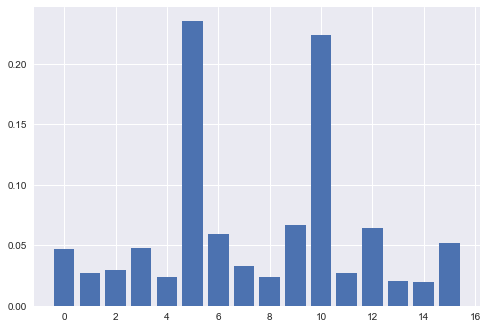

In [21]:
plt.style.use("seaborn")
plt.bar(range(2 ** len(wires)), probs)
plt.savefig(savestring + ".png")
plt.show()

5 = 0101
10 = 1010


ALSO ALLES RICHTIG

PANNYLANE MY GODNESS